In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
X = np.load("np_arrays/X.npy")
y = np.load("np_arrays/y.npy")

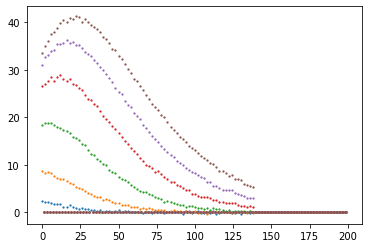

In [3]:
for i in range(6):
    plt.scatter(x=np.arange(200), y = X[921,:,i], s=1.5)

In [4]:
X_plasticc = np.load("../centering-time-series-plasticc/np_arrays/X.npy")
y_plasticc = np.load("../centering-time-series-plasticc/np_arrays/y.npy")

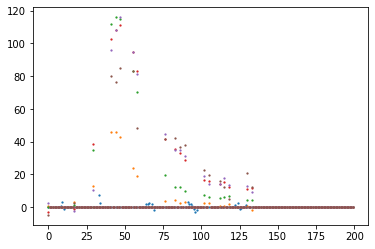

In [5]:
for i in range(6):
    plt.scatter(x=np.arange(200), y = X_plasticc[323,:,i], s=1.5)

# PLAsTiCC like Downsampling
### Strategy:
- First fill "u" in sims based on plasticc frequency.
- Choose where "u" is zero in sims, then based on plasticc frequency for "g", fill grizY of sims
- Choose where "ugrizy" all are 0 in sims. Then check if frequency for "z" is more than freq for "g". If yes, fill the chosen sims as per frequency.
- Choose where "ugrizy" all are 0 in sims. Then check if frequency for "Y" is more than freq for "z". If yes, fill the chosen sims as per frequency.

(Note: I came up with this strategy after examining the PLAsTiCC data manually. Click cell to read more.)
<!--  Code I used:

for j in tqdm(range(len(X_plasticc))):
    df2 = pd.DataFrame(X_plasticc[j],columns=bands)
#     c1 = len(df2[(df2["g"]!=0)]) == len(df2[(df2["g"]!=0) &
#                                               (df2["r"]!=0) &
#                                               (df2["i"]!=0) &
#                                               (df2["z"]!=0) &
#                                               (df2["Y"]!=0)
#                                              ])
    
#     c2 = len(df2[(df2["g"]!=0)]) == len(df2[(df2["g"]!=0) &
#                                               (df2["r"]!=0) &
#                                               (df2["i"]!=0) &
#                                               (df2["z"]!=0) &
#                                               (df2["Y"]!=0)
#                                              ]) + 1

#     c3 = len(df2[(df2["g"]!=0)]) == len(df2[(df2["g"]!=0) &
#                                               (df2["r"]!=0) &
#                                               (df2["i"]!=0) &
#                                               (df2["z"]!=0) &
#                                               (df2["Y"]!=0)
#                                              ]) + 2

    c4 = len(df2[(df2["g"]!=0)]) == len(df2[(df2["g"]!=0) &
                                              (df2["r"]!=0) &
                                              (df2["i"]!=0)
                                             ])

    assert (c4)
-->

In [6]:
bad_downsample_counter = 0
X_miss_asplasticc = []
bands = ["u","g","r","i","z","Y"]
for i in tqdm(range(len(X))):
    cur_class = y[i]
    plasticc_idx = np.random.choice(np.argwhere(y_plasticc==cur_class).reshape(-1),1)[0]
    plasticc_arr = X_plasticc[plasticc_idx]
    df_plasticc = pd.DataFrame(X_plasticc[plasticc_idx],columns=bands)
    df_sims = pd.DataFrame(X[i],columns=bands)

    # Count where u is not zero
    c_u = len(df_plasticc[df_plasticc["u"]!=0])

    # Count where grizy are not zero
    c_grizy = len(df_plasticc[
        (df_plasticc["g"]!=0) &
        (df_plasticc["r"]!=0) &
        (df_plasticc["i"]!=0) &
        (df_plasticc["z"]!=0) &
        (df_plasticc["Y"]!=0)   
    ])

    # Count where griz are not zero
    c_griz = len(df_plasticc[
        (df_plasticc["g"]!=0) &
        (df_plasticc["r"]!=0) &
        (df_plasticc["i"]!=0) &
        (df_plasticc["z"]!=0)
    ])

    # Count where gri are not zero
    c_gri = len(df_plasticc[
        (df_plasticc["g"]!=0) &
        (df_plasticc["r"]!=0) &
        (df_plasticc["i"]!=0)
    ])
    
    newdf = pd.DataFrame(0, index=df_sims.index, columns=bands)
    # u
    try:
        tempseries = df_sims.loc[df_sims["u"]!=0,"u"].sample(n=c_u).sort_index()
    except ValueError:
        tempseries = df_sims.loc[df_sims["u"]!=0,"u"].sort_index()
        assert len(tempseries) < c_u
        bad_downsample_counter+=1
    newdf.loc[tempseries.index,"u"] = tempseries

    # grizy
    try:
        tempseries = df_sims.loc[(newdf["u"]==0) & (df_sims["g"]!=0),
                             ["g","r","i","z","Y"]].sample(n=c_grizy).sort_index()
    except ValueError:
        tempseries = df_sims.loc[(newdf["u"]==0) & (df_sims["g"]!=0),
                             ["g","r","i","z","Y"]].sort_index()
        assert len(tempseries) < c_grizy
        bad_downsample_counter+=1

    newdf.loc[tempseries.index,["g","r","i","z","Y"]] = tempseries

    if c_grizy>c_griz:
        tempseries = df_sims.loc[(newdf["u"]==0) & (newdf["g"]==0) & (df_sims["z"]!=0),
                         ["z","Y"]].sample(n=(c_grizy - c_griz)).sort_index()
        newdf.loc[tempseries.index,["z","Y"]] = tempseries

        if c_griz>c_gri:
            tempseries = df_sims.loc[(newdf["u"]==0) & (newdf["g"]==0) & (newdf["z"]==0) & (df_sims["Y"]!=0),
                         ["Y"]].sample(n=(c_griz - c_gri)).sort_index()
            newdf.loc[tempseries.index,["Y"]] = tempseries
    
    X_miss_asplasticc.append(newdf.to_numpy())

print(f"Downsample was not ideal for {bad_downsample_counter}/{len(X_miss_asplasticc)} objects")
X_miss_asplasticc = np.array(X_miss_asplasticc)

  0%|          | 0/4000 [00:00<?, ?it/s]

Downsample was not ideal for 741/4000 objects


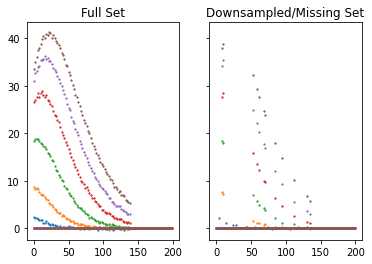

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for i in range(6):
    ax1.scatter(x=np.arange(200), y = X[921,:,i], s=1.5)
    ax1.set_title("Full Set")
for i in range(6):
    ax2.scatter(x=np.arange(200), y = X_miss_asplasticc[921,:,i], s=1.5)
    ax2.set_title("Downsampled/Missing Set")

In [8]:
np.save("np_arrays/X_miss_asplasticc.npy",X_miss_asplasticc)

In [9]:
del(X_miss_asplasticc,X_plasticc)

# Drop 50% of data from each column

In [10]:
X_miss_50 = []
bands = ["u","g","r","i","z","Y"]
for i in tqdm(range(len(X))):
    df_sims = pd.DataFrame(X[i],columns=bands)
    for band in bands:
        reset_idx = np.sort(np.random.choice(df_sims.index,size=len(df_sims)//2,replace=False))
        df_sims.loc[reset_idx,band] = 0
    X_miss_50.append(df_sims.to_numpy())
X_miss_50 = np.array(X_miss_50)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [11]:
X = np.load("np_arrays/X.npy")

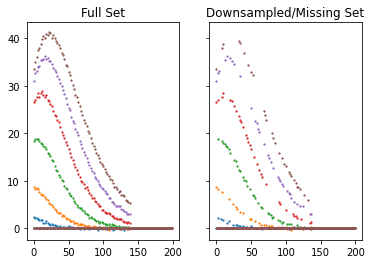

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for i in range(6):
    ax1.scatter(x=np.arange(200), y = X[921,:,i], s=1.5)
    ax1.set_title("Full Set")
for i in range(6):
    ax2.scatter(x=np.arange(200), y = X_miss_50[921,:,i], s=1.5)
    ax2.set_title("Downsampled/Missing Set")

In [13]:
np.save("np_arrays/X_miss_50.npy",X_miss_50)